# Aligning and combining the science images

- Use find_transform() and apply_transform() to align all flat-fielded science images to a common reference image (e.g., science1Vf.fits).
- Make sure to check that the transformations have been determined correctly! Print out a table with the following information:
    - The image names.
    - The (x, y) shifts.
    - The rotations. 
    - The scales.
    
  The rotations should all be less than 0.01 deg (abs(T.rotation*180/math.pi) < 0.01) and the scale changes should deviate by less than 0.0002 from unity (abs(T.scale - 1) < 0.0002).
  
- Use ccdproc.combine() to produce a final co-added image in each band. Unlike the flat-fields, these should not be normalised. Copy the first extension to the final files, Vfinal.fits and rfinal.fits, to be used in further analysis.

In [1]:
import astroalign as aa
import astropy.io.fits as fits
import imexam
import time
import math
import numpy as np
import ccdproc
import os
import shutil

def align_images(source_filename, target_filename, output_filename):
    datatarget = fits.getdata(target_filename)
    datasrc = fits.getdata(source_filename)
    T, (source_pos_array, target_pos_array) = aa.find_transform(datasrc, datatarget)
    print("Image name = {}  shifts= {} rot= {}  scale = {}"
          .format(source_filename, T.translation, T.rotation*180/math.pi, T.scale))
    assert(abs(T.rotation*180/math.pi)<0.01) # Ensure the rotation is not too big
    assert(abs(T.scale -1) < 0.0002) # Ensure the scale is not to different
    data_tran, footprint = aa.apply_transform(T, np.int32(datasrc), np.int32(datatarget))
    
    fits.writeto(output_filename, data_tran, overwrite=True)
    
# Align the flat-fielded science images:
def align_multiple_images(target_filename, source_filenames, output_filenames):
    for i in range(len(source_filenames)):
        source_filename = source_filenames[i]
        output_filename = output_filenames[i]
        align_images(source_filename, target_filename, output_filename)

Ginga not installed, use other viewer, or no viewer


Make sure all shifts and rotations are small before proceeding to the next step!

Now combine the aligned science images:

In [2]:
# Combine the aligned science images


def combine_and_align_images(science_filenames, align_target, output_filename):
    temp_filenames = ["temp{}.fits".format(i) for i in range(len(science_filenames))]
    align_multiple_images(align_target, science_filenames, temp_filenames)
    sciVavg = ccdproc.combine(temp_filenames, method="average", unit="adu")
    print(np.array(sciVavg).mean())

    # Save the output
    sciVavg.write('tmpcmb.fits',overwrite=True)
    # ...
    cmb, hdr = fits.getdata('tmpcmb.fits',0, header=True)
    fits.writeto(output_filename, cmb, hdr, overwrite=True)
    print('Done!')
    

align_target = "science1Vf.fits"    
filenames_V = ["science{}Vf.fits".format(i) for i in range(1,11)]
combine_and_align_images(filenames_V, align_target, "Vfinal.fits")

filenames_R = ["science{}rf.fits".format(i) for i in range(1,11)]
combine_and_align_images(filenames_R, align_target, "rfinal.fits")

Image name = science1Vf.fits  shifts= [2.72848411e-12 1.13686838e-12] rot= 2.7561228414667095e-15  scale = 0.9999999999999981
Image name = science2Vf.fits  shifts= [0.7784693  2.26726514] rot= 0.0014774902792273116  scale = 0.9999521406027819
Image name = science3Vf.fits  shifts= [-0.05771012 -0.82430355] rot= 0.00144578368095527  scale = 0.9999890642577759
Image name = science4Vf.fits  shifts= [ 0.27624008 -2.05972096] rot= -0.00016279504650910592  scale = 0.9999248171561275
Image name = science5Vf.fits  shifts= [-0.63085225 -2.45246129] rot= 0.0008165647766147093  scale = 0.9999038499432898
Image name = science6Vf.fits  shifts= [-0.63392496  1.19948939] rot= -0.00013732716318343686  scale = 0.9999332652644058
Image name = science7Vf.fits  shifts= [0.17820856 0.39023461] rot= 0.0005427399251707635  scale = 0.9999157918342961
Image name = science8Vf.fits  shifts= [-0.00297399  1.08860376] rot= 0.0004271928706616981  scale = 0.9999611562944112
Image name = science9Vf.fits  shifts= [-0.2

Display the combined images:

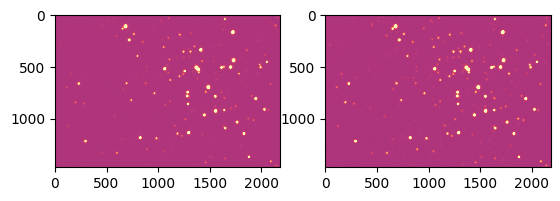

In [3]:
import matplotlib.pyplot as plt
dataV = fits.getdata("Vfinal.fits")
dataR = fits.getdata("rfinal.fits")

mean_V = np.mean(dataV)
std_V = np.std(dataV)
mean_R = np.mean(dataR)
std_R = np.std(dataR)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(dataV, vmin=mean_V-2*std_V, vmax=mean_V+2*std_V, cmap='magma')
axarr[1].imshow(dataR, vmin=mean_R-2*std_R, vmax=mean_R+2*std_R, cmap='magma')

# Hand in

The completed notebook (as PDF via Brightspace), including 
- the listing of transformation parameters (50/100 pts), 
- the code to combine the aligned images (25/100 pts)
- the display of the two combined images (25/100 pts)